# Import Libraries

In [1]:
%matplotlib inline
!pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torchsummary import summary

# Initial setup

In [2]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available? ", cuda)

device = "cuda:0" if cuda else "cpu"

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available?  True


# Data Augmentation

In [3]:
train_transforms = transforms.Compose([
    transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


# Dataset and Dataloaders

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [5]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

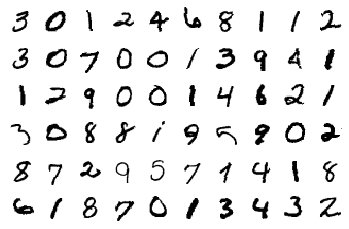

In [6]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(num_of_images // 10, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
# plt.imshow(images[1].numpy().squeeze(), cmap="gray_r")

# The model

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        dropout_prob = 0.05
        self.input_block = nn.Sequential(
            nn.Conv2d(1, 12, 3, padding=0),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout2d(dropout_prob)
        )
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(12, 12, 3, padding=0),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout2d(dropout_prob)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(12, 14, 3, padding=0),
            nn.BatchNorm2d(14),
            nn.ReLU(),
            nn.Dropout2d(dropout_prob)
        )

        self.transition_1 = nn.Sequential(
            nn.Conv2d(14, 10, 1, padding=0),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout2d(dropout_prob),
            nn.MaxPool2d(2, 2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(10, 16, 3, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(dropout_prob)
        )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(dropout_prob)
        )
        self.conv_block_5 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(dropout_prob)
        )
        self.out_block = nn.Sequential(
            nn.AvgPool2d(7),
            nn.Conv2d(16, 10, 1, padding=0)
        )

    def forward(self, x):
        x = self.input_block(x)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.transition_1(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.conv_block_5(x)
        x = self.out_block(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [17]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
         Dropout2d-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,308
       BatchNorm2d-6           [-1, 12, 24, 24]              24
              ReLU-7           [-1, 12, 24, 24]               0
         Dropout2d-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 14, 22, 22]           1,526
      BatchNorm2d-10           [-1, 14, 22, 22]              28
             ReLU-11           [-1, 14, 22, 22]               0
        Dropout2d-12           [-1, 14, 22, 22]               0
           Conv2d-13           [-1, 10, 22, 22]             150
      BatchNorm2d-14           [-1, 10,

# Training and Testing

In [9]:
from pkbar import Kbar

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = Kbar(len(train_loader), width=12)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # getting data
        data, target = data.to(device), target.to(device)

        # zeroing out leftover gradients
        optimizer.zero_grad()

        # predict
        y_pred = model(data)

        # calculating loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # backpropagation
        loss.backward()
        optimizer.step()
        
        # calculating accuracy
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        acc = 100*correct/processed
        train_acc.append(acc)

        # updating progress bar
        pbar.update(batch_idx, values=[('loss', loss.item()), ('accuracy', acc)])
        
    pbar.add(1, values=[('loss', loss.item()), ('accuracy', acc)])

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [18]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)
epochs = 15
for epoch in range(epochs):
    print("Epoch:", epoch + 1, "/", epochs)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Epoch: 1 / 15
469/469 [============] - 8s 17ms/step - loss: 1.0392 - accuracy: 49.1125
Test set: Average loss: 0.1913, Accuracy: 9606/10000 (96.06%)

Epoch: 2 / 15
469/469 [============] - 8s 16ms/step - loss: 0.2845 - accuracy: 90.8459
Test set: Average loss: 0.0810, Accuracy: 9801/10000 (98.01%)

Epoch: 3 / 15
469/469 [============] - 8s 16ms/step - loss: 0.2012 - accuracy: 93.5797
Test set: Average loss: 0.0614, Accuracy: 9831/10000 (98.31%)

Epoch: 4 / 15
469/469 [============] - 7s 16ms/step - loss: 0.1653 - accuracy: 94.9289
Test set: Average loss: 0.0490, Accuracy: 9854/10000 (98.54%)

Epoch: 5 / 15
469/469 [============] - 7s 16ms/step - loss: 0.1491 - accuracy: 95.4372
Test set: Average loss: 0.0418, Accuracy: 9882/10000 (98.82%)

Epoch: 6 / 15
469/469 [============] - 7s 16ms/step - loss: 0.1309 - accuracy: 95.9786
Test set: Average loss: 0.0392, Accuracy: 9876/10000 (98.76%)

Epoch: 7 / 15
469/469 [============] - 7s 16ms/step - loss: 0.1249 - accuracy: 95.9730
Test set: Ave

Text(0.5, 1.0, 'Test Accuracy')

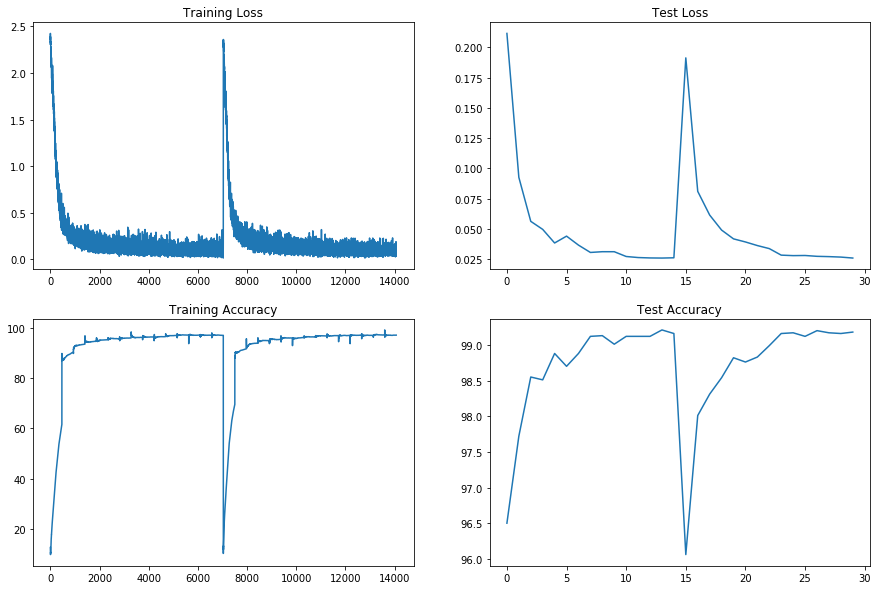

In [19]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")